In [9]:
import os
import warnings
warnings.filterwarnings('ignore')
import scanpy as sc
import pandas as pd
import numpy as np
import scvi

import matplotlib.pyplot as plt
import mplscience

In [ ]:
import mygene

# R integration
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [2]:
os.chdir('../../')

# 1. Check samples

In [6]:
tnl = sc.read_h5ad('output/tnl.h5ad')
tnl.obs['author'] = 'tnl'
tnl.obs['method'] = 'nuclei'
tnl.obs['assay'] = "10x 3' v3"

In [7]:
cptac = sc.read_h5ad('output/cptac.h5ad')
cptac.obs['author'] = 'cptac'
cptac.obs['method'] = 'nuclei'
cptac.obs['assay'] = "10x 3' v3"

In [8]:
wang = sc.read_h5ad('output/wang2024.h5ad')
wang.obs['author'] = 'wang2024'
wang.obs['method'] = 'nuclei'
wang.obs['assay'] = "DNBelab C Series Single-Cell Library Prep Set"

In [23]:
adata = sc.read_h5ad('output/extended_gbmap_filtered.h5ad')
adata

AnnData object with n_obs × n_vars = 819910 × 26302
    obs: 'author', 'donor_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'annotation_level_1', 'annotation_level_2', 'annotation_level_3', 'gbmap', 'method', 'stage', 'location', 'sector', 'celltype_original', 'EGFR', 'MET', 'p53', 'TERT', 'ATRX', 'PTEN', 'MGMT', 'chr1p19q', 'PDGFR', 'suspension_type', 'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'X_approximate_dis

In [30]:
tnl.obs['cell_type'] = tnl.obs['celltype']
cptac.obs['cell_type'] = cptac.obs['celltype']
wang.obs['cell_type'] = wang.obs['celltype']

In [74]:
tnl.var_names_make_unique()
cptac.var_names_make_unique()
wang.var_names_make_unique()
adata.var_names_make_unique()

In [75]:
np.max(tnl.X), np.max(cptac.X), np.max(wang.X), np.max(adata.X)

(4190.0, 7478.0, 2146.0, 216739.0)

In [ ]:
ro.r('library(HGNChelper)')

def standardize_hgnc_symbols(adata):
    original_symbols = adata.var_names.tolist()
    gene_symbols_r = ro.StrVector(original_symbols)

    ro.globalenv['genes'] = gene_symbols_r
    ro.r('gene_check <- checkGeneSymbols(genes, unmapped.as.na=FALSE)')
    ro.r('unique_symbols <- make.unique(gene_check$Suggested.Symbol)')
    unique_symbols = list(ro.r('unique_symbols'))
    
    adata.var_names = unique_symbols
    return adata

In [90]:
datasets = [tnl, cptac, wang, adata]

In [91]:
standardized_datasets = [standardize_hgnc_symbols(ds) for ds in datasets]

In [94]:
full = sc.concat(standardized_datasets, join='outer')

In [98]:
full.obs = full.obs[['author', 'method', 'assay', 'donor_id', 'gs_prediction_main', 'SingleR', 'predicted.annotation_level_3', 'predicted.annotation_level_4.score', 'predicted.annotation_level_4', 'copykat', 'cell_type']].copy()

In [99]:
# full.write('output/full.h5ad')

In [ ]:
sc.pp.filter_genes(adata, min_cells=1000)

In [ ]:
# zero_genes = adata.var_names[adata.X.getnnz(axis=0) < 100]

In [121]:
# sum(adata.X.sum(axis = 1).A1 > 100)

1135345

In [ ]:
adata.raw = adata
adata.layers['counts'] = adata.X.copy()

In [ ]:
np.max(adata.X)

216739.0

In [139]:
adata.raw = adata
adata.layers['counts'] = adata.X.copy()

In [ ]:
sc.pp.highly_variable_genes(adata, flavor = 'seurat_v3', n_top_genes=5000, batch_key="author", subset=True)

In [ ]:
# full.write('output/full_filtered.h5ad')

# 2. Integrate

- pytorch:2.4.0-py3.11-cuda12.4.1-devel-ubuntu22.04
- L4 (needs about 200GB ram , not VRAM)
- output : `full_scanvi_model`, `full_scvi_model`, `map.h5ad`

In [2]:
!pip install scanpy scikit-misc scvi-tools mplscience igraph leidenalg

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 190.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 221.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 186.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 236.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 238.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 MB 200.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 230.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
os.chdir('/workspace')
import gc
import warnings
warnings.filterwarnings("ignore")

# single cell pipelines
import scanpy as sc
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import mplscience

# scvi-tools
import scvi
import torch

print(scvi.__version__)
sc.logging.print_header()

np.random.seed(777)
torch.manual_seed(777)
scvi.settings.seed = 777

torch.set_float32_matmul_precision("high")

1.2.2.post2


Seed set to 777


scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==1.26.3 scipy==1.15.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [5]:
adata = sc.read_h5ad('full_filtered.h5ad')
adata

AnnData object with n_obs × n_vars = 1135345 × 5000
    obs: 'author', 'method', 'assay', 'donor_id', 'gs_prediction_main', 'SingleR', 'predicted.annotation_level_3', 'predicted.annotation_level_4.score', 'predicted.annotation_level_4', 'copykat', 'cell_type'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [6]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts", batch_key="author", labels_key="cell_type")

In [7]:
scvi_model = scvi.model.SCVI(
    adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

scvi_model.train(
    max_epochs=500,
    early_stopping=True,
    early_stopping_monitor="elbo_validation", 
    early_stopping_patience=10,
    plan_kwargs={
        "reduce_lr_on_plateau": True,
        "lr_factor": 0.1,
        "lr_patience": 8,
        "lr_scheduler_metric": "elbo_validation",
    },
)

scvi_model.save('full_scvi_model')

In [ ]:
with mplscience.style_context():
    y = scvi_model.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()
    plt.plot(scvi_model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label = 'validation')
    plt.plot(scvi_model.history['reconstruction_loss_train']['reconstruction_loss_train'], label = 'train')

    plt.axhline(y, c = 'k')
    plt.legend()
    plt.show()

In [8]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)

scanvi_model.train(
    max_epochs=200,
    early_stopping=True,
    early_stopping_monitor="validation_classification_loss",  # or accuracy
    early_stopping_min_delta=0.001,
    early_stopping_patience=10,
    plan_kwargs={
        "reduce_lr_on_plateau": True,
        "lr_factor": 0.1,
        "lr_patience": 8,
        "lr_scheduler_metric": "validation_classification_loss",
    },
)

scanvi_model.save('full_scanvi_model')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/500 [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
with mplscience.style_context():
    y = scanvi_model.history['validation_classification_loss']['validation_classification_loss'].min()
    plt.plot(scanvi_model.history['train_classification_loss']['train_classification_loss'], label = 'validation')
    plt.plot(scanvi_model.history['validation_classification_loss']['validation_classification_loss'], label = 'train')

    plt.axhline(y, c = 'k')
    plt.legend()
    plt.show()

In [ ]:
bdata = adata.raw.to_adata()
bdata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)
bdata.write('map.h5ad')

# 3. Reannotate

In [3]:
adata = sc.read_h5ad('output/map.h5ad')
adata

AnnData object with n_obs × n_vars = 1135345 × 29437
    obs: 'author', 'method', 'assay', 'donor_id', 'gs_prediction_main', 'SingleR', 'predicted.annotation_level_3', 'predicted.annotation_level_4.score', 'predicted.annotation_level_4', 'copykat', 'cell_type', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg'
    obsm: 'X_pca', 'X_scANVI', 'X_umap'

In [4]:
sc.pp.neighbors(adata, use_rep="X_scANVI")

In [5]:
sc.tl.umap(adata)

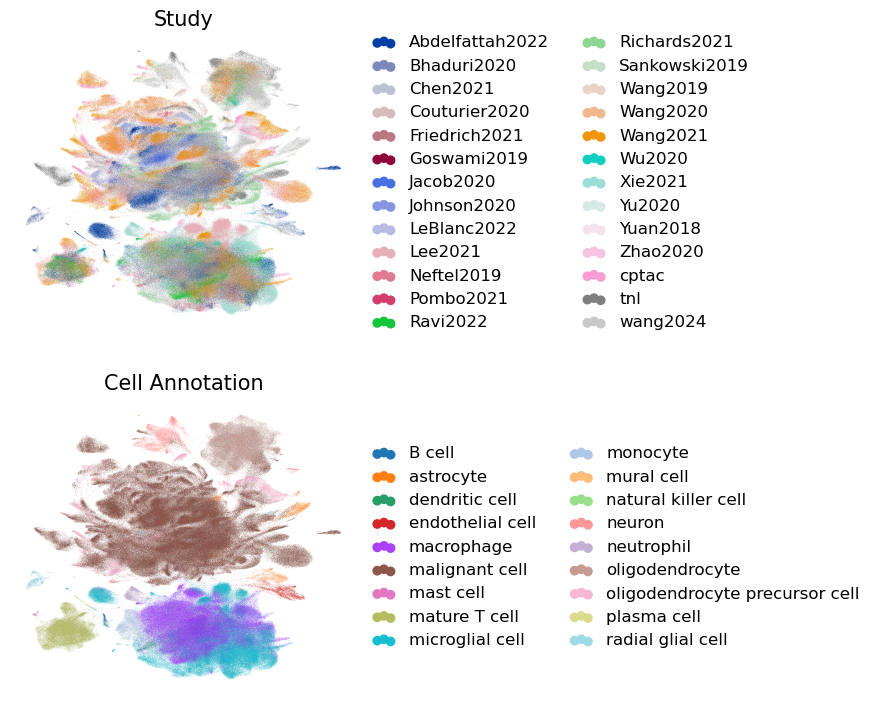

In [12]:
with mplscience.style_context():
    sc.pl.umap(adata, color = ['author', 'cell_type'], ncols = 1, frameon = False, title = ['Study', 'Cell Annotation'])

In [10]:
adata.write('output/map.h5ad')